<a href="https://colab.research.google.com/github/arjunks95/healthcare-ml/blob/main/Pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Loading data to Gdrive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [ ]:
%cd /content/drive/MyDrive/Kaggle/chest_xray

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [ ]:
!ls

###Unzip

###Visualise the images

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Dropout,Softmax,Input,Flatten
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
#from tensorflow.keras.layers.merge import add
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score,recall_score
from tensorflow.keras.metrics import categorical_accuracy
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import PIL
from PIL import Image
import os

In [ ]:
import cv2

In [ ]:
mainDIR = os.listdir('/content/drive/MyDrive/Kaggle/chest_xray/chest_xray/')
print(mainDIR)

['.DS_Store', 'test', 'train', 'val']


In [ ]:
train_folder= '/content/drive/MyDrive/Kaggle/chest_xray/chest_xray/train/'
val_folder = '/content/drive/MyDrive/Kaggle/chest_xray/chest_xray/val/'
test_folder = '/content/drive/MyDrive/Kaggle/chest_xray/chest_xray/test/'

In [ ]:
# train 
os.listdir(train_folder)
train_n = train_folder+'NORMAL/'
train_p = train_folder+'PNEUMONIA/'

No of normal images in train  1342
normal picture title:  IM-0239-0001.jpeg
No of pneumonia images in train  3876
pneumonia picture title: person465_virus_957.jpeg


Text(0.5, 1.0, 'Pneumonia')

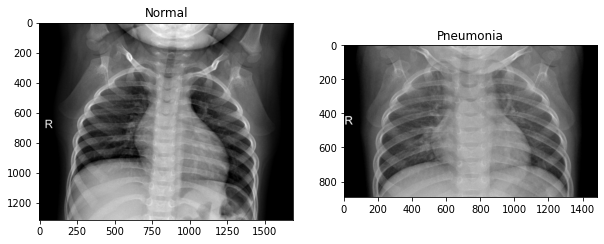

In [ ]:
#Normal pic 
print('No of normal images in train ',len(os.listdir(train_n)))
rand_norm= np.random.randint(0,len(os.listdir(train_n)))
norm_pic = os.listdir(train_n)[rand_norm]
print('normal picture title: ',norm_pic)

norm_pic_address = train_n+norm_pic

#Pneumonia
rand_p = np.random.randint(0,len(os.listdir(train_p)))
print('No of pneumonia images in train ',len(os.listdir(train_p)))

sic_pic =  os.listdir(train_p)[rand_norm]
sic_address = train_p+sic_pic
print('pneumonia picture title:', sic_pic)
'''
# Load the images
norm_load = Image.open(norm_pic_address)
sic_load = Image.open(sic_address)
'''
#Let's plt these images
f = plt.figure(figsize= (10,6))
a1 = f.add_subplot(1,2,1)
normal_img =  cv2.imread(norm_pic_address)
plt.imshow(normal_img)
a1.set_title('Normal')

a2 = f.add_subplot(1, 2, 2)
p_img =  cv2.imread(sic_address)
plt.imshow(p_img)
#img_plot = plt.imshow(sic_load,cmap='gray')
a2.set_title('Pneumonia')




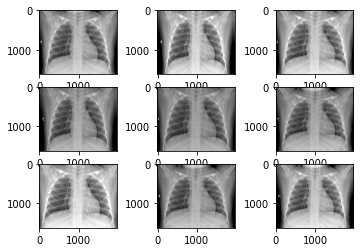

In [ ]:
# Trial of Image data generator since the number of normal images were lesser
from tensorflow.keras.preprocessing.image import load_img,img_to_array
img = load_img(norm_pic_address)
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = np.expand_dims(data, 0)
#datagen = ImageDataGenerator(brightness_range=[0.7,1.3])
datagen = ImageDataGenerator(
        #rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        #vertical_flip=True
        zoom_range = 0.1, # Randomly zoom image 
        brightness_range=[0.8,1.2])
        #shear_range=0.2)
        #width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        #height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        #horizontal_flip = True,  # randomly flip images
        #vertical_flip=True)  # randomly flip images
# prepare iterator
it = datagen.flow(samples, batch_size=1)


for i in range(9):
	plt.subplot(330+i+1)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	plt.imshow(image)
# show the figure
plt.show() 

In [ ]:


list = os.listdir('/content/drive/MyDrive/Kaggle/chest_xray/chest_xray/train/NORMAL') # dir is your directory path
number_files = len(list)
print(number_files)

1342


####Model Build

In [ ]:
# Fitting the CNN to the images
# The function ImageDataGenerator augments your image by iterating through image as your CNN is getting ready to process that image

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2)
                                   #horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)  #Image normalization.

training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Kaggle/chest_xray/chest_xray/train',
                                                 target_size = (200, 200),
                                                 batch_size = 32,
                                                 class_mode = 'binary',shuffle=True)

validation_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Kaggle/chest_xray/chest_xray/val',
    target_size=(200, 200),
    batch_size=16,
    class_mode='binary',shuffle=True)

test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Kaggle/chest_xray/chest_xray/test',
                                            target_size = (200, 200),
                                            batch_size = 8,
                                            class_mode = 'binary',shuffle=False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:

cnn = Sequential()

#Convolution
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(200, 200, 3)))

#Pooling
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# 2nd Convolution
cnn.add(Conv2D(32, (3, 3), activation="relu"))

# 2nd Pooling layer
cnn.add(MaxPooling2D(pool_size = (2, 2)))

#3rd Convolution
cnn.add(Conv2D(32,(3,3),activation='relu'))

#3rd Pooling Layer
cnn.add(MaxPooling2D(pool_size=(2,2)))

# Flatten the layer
cnn.add(Flatten())

# Fully Connected Layers
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'sigmoid', units = 1))

# Compile the Neural network
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
#callback monitoring validation accuracy and reducing Learning rate by a factor of 0.1 upon reaching plateau, to prevent
# overfitting 
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,
                              patience=2, min_lr=0.001)


In [ ]:
history=cnn.fit(training_set,validation_data=validation_set,callbacks=[reduce_lr],epochs=15)

Epoch 1/15
163/163 [==============================] - 2334s 14s/step - loss: 0.4505 - accuracy: 0.7906 - val_loss: 0.8372 - val_accuracy: 0.6250
Epoch 2/15
163/163 [==============================] - 88s 541ms/step - loss: 0.2311 - accuracy: 0.9085 - val_loss: 0.5427 - val_accuracy: 0.6875
Epoch 3/15
163/163 [==============================] - 89s 546ms/step - loss: 0.1972 - accuracy: 0.9252 - val_loss: 0.6295 - val_accuracy: 0.6250
Epoch 4/15
163/163 [==============================] - 89s 544ms/step - loss: 0.1657 - accuracy: 0.9344 - val_loss: 0.2093 - val_accuracy: 0.9375
Epoch 5/15
163/163 [==============================] - 88s 543ms/step - loss: 0.1484 - accuracy: 0.9429 - val_loss: 0.6342 - val_accuracy: 0.6875
Epoch 6/15
163/163 [==============================] - 89s 548ms/step - loss: 0.1474 - accuracy: 0.9467 - val_loss: 0.4273 - val_accuracy: 0.8125
Epoch 7/15
163/163 [==============================] - 89s 543ms/step - loss: 0.1412 - accuracy: 0.9468 - val_loss: 0.6479 - val_ac

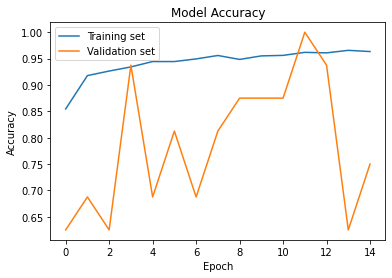

In [ ]:
# The variation of training accuracy vs validation set accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()

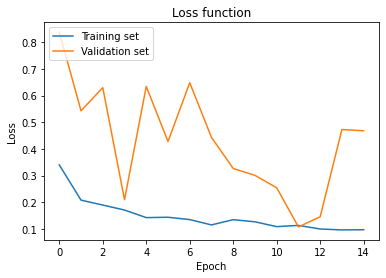

In [ ]:
# Validation loss vs Training loss
plt.plot(history.history["loss"])
plt.plot(history.history['val_loss'])
plt.title('Loss function')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()

In [ ]:
test_accu = cnn.evaluate(test_set)
#Test set reports an accuracy of 86.22%

78/78 [==============================] - 253s 3s/step - loss: 0.5143 - accuracy: 0.8830


In [ ]:
p = cnn.predict(test_set, verbose=True)

78/78 [==============================] - 6s 73ms/step


In [ ]:
#Creating a DF of the sigmoid probability output 
pre3 = pd.DataFrame(p)
pre3["filename"] = test_set.filenames
pre3["label"] = (pre3["filename"].str.contains("PNEUMONIA")).apply(int)# Generating actual labels based on filename
pre3["pre"] = (pre3[0]>0.5).apply(int) # giving a value of one where softmax function has returned probability >0.5

In [ ]:
pre3
np.argmax(pre3[0])

246

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


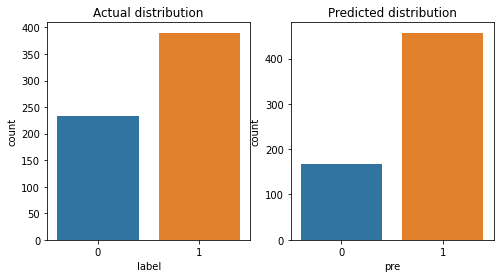

In [ ]:
import seaborn as sns
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
sns.countplot(pre3['label'])
plt.title('Actual distribution')
plt.subplot(1,2,2)
sns.countplot(pre3['pre'],)
plt.title('Predicted distribution')
plt.show()

In [ ]:
recall_score(pre3["label"],pre3["pre"])

0.9923076923076923

In [ ]:
roc_auc_score(pre3["label"],pre3[0])


0.9532160859083936

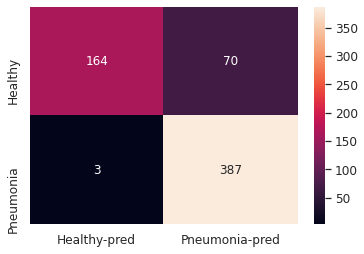

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm=confusion_matrix(pre3["label"],pre3["pre"])
df_cm = pd.DataFrame(cm, ['Healthy','Pneumonia'],['Healthy-pred','Pneumonia-pred'])
sns.set(font_scale=1.1)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 12},fmt='g')
plt.show()

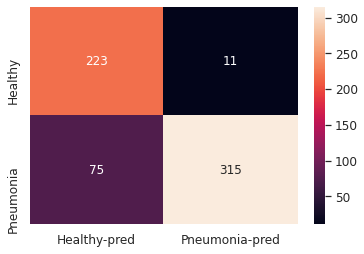

In [ ]:
from sklearn.metrics import confusion_matrix ##Old model built has more False Negatives hence neglected
import seaborn as sns
cm=confusion_matrix(pre3["label"],pre3["pre"])
df_cm = pd.DataFrame(cm, ['Healthy','Pneumonia'],['Healthy-pred','Pneumonia-pred'])
sns.set(font_scale=1.1)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 12},fmt='g')
plt.show()

In [ ]:
accuracy_score(pre3["label"],pre3["pre"])

0.8830128205128205

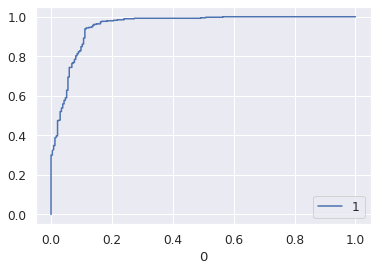

In [ ]:
tpr,fpr,thres = roc_curve(pre3["label"],pre3[0])
roc = pd.DataFrame([tpr,fpr]).T
roc.plot(x=0,y=1)


In [ ]:
from sklearn.metrics import f1_score
print("The F1 score for the final model on test set is {:.2f}".format(f1_score(pre3["label"],pre3["pre"])*100))

The F1 score for the final model on test set is 91.38


In [ ]:
pre3['pre'].value_counts()

1    326
0    298
Name: pre, dtype: int64

In [ ]:
pre3['label'].value_counts()

1    390
0    234
Name: label, dtype: int64

In [ ]:
cnn.save('/content/drive/MyDrive/updatedfinal_CNN.h5')

####References
https://www.mayoclinic.org/diseases-conditions/pneumonia/multimedia/chest-x-ray-showing-pneumonia/img-20005827

https://keras.io/api/models/model_training_apis/

https://www.coursera.org/specializations/ai-for-medicine

https://www.kaggle.com/michalbrezk/x-ray-pneumonia-cnn-tensorflow-2-0-keras-94

https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851a

https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

https://www.kaggle.com/sanwal092/intro-to-cnn-using-keras-to-predict-pneumonia

https://www.kaggle.com/alifrahman/pneumonia-detection-with-cnn-auc-score-0-94

https://www.kaggle.com/cosmosankur/cnn-keras-for-by-beginner

https://www.kaggle.com/aayushmishra1512/pneumonia-detection-using-cnn

Data:
https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia